# Noisy Amplifier

The most simplistic model for an amplifier is just the product of a signal with some factor (gain). But we all know, real amplifiers are noisy and nonlinear. Internal physical processes or fluctiations in the power supply produce noise and if the amplitudes get too big, we run into saturations. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection, Subsystem, Interface

from pathsim.blocks import (
    Scope, Spectrum, Amplifier, Function, Adder, WhiteNoise, 
    PinkNoise, SinusoidalSource, ButterworthLowpassFilter
    )

# For the automatic differentiation
from pathsim.optim import Value, der

## Noisy Amplifier Model as Subsystem

In [4]:
# System parameters

a  = 10   # gain
fc = 1e6  # bandwidth
n  = 2    # filter order

# For sensitivity analysis
psd_w, psd_p = Value.array([1e-9, 1e-10])

In [6]:
# Internal subsystem blocks for the noisy amplifier

amp_int = Interface()
amp_wns = WhiteNoise(spectral_density=psd_w)
amp_pns = PinkNoise(spectral_density=psd_p)
amp_add = Adder()
amp_sat = Function(np.tanh)
amp_amp = Amplifier(a)
amp_flt = ButterworthLowpassFilter(fc, n)

amp_blocks = [amp_int, amp_wns, amp_pns, amp_add, amp_flt, amp_amp, amp_sat]

amp_connections = [
    Connection(amp_int, amp_add[0]),
    Connection(amp_wns, amp_add[1]),
    Connection(amp_pns, amp_add[2]),
    Connection(amp_add, amp_sat),
    Connection(amp_sat, amp_amp),
    Connection(amp_amp, amp_flt),
    Connection(amp_flt, amp_int)
    ]

AMP = Subsystem(amp_blocks, amp_connections)

## Main System (Top Level)

In [9]:
Src = SinusoidalSource(frequency=2e5, amplitude=1)
Sco = Scope(labels=["Src", "AMP"])
Spc = Spectrum(freq=np.logspace(4.1, 7, 250), labels=["Src", "AMP"])

blocks = [AMP, Src, Sco, Spc]

connections = [
    Connection(Src, AMP, Sco[0], Spc[0]),
    Connection(AMP, Sco[1], Spc[1])
    ]

In [11]:
Sim = Simulation(
    blocks, 
    connections, 
    dt=3e-8, 
    log=True
    )

2025-10-22 22:30:06,201 - INFO - LOGGING (log: True)
2025-10-22 22:30:06,203 - INFO - BLOCK (type: Subsystem, dynamic: True, events: 0)
2025-10-22 22:30:06,203 - INFO - BLOCK (type: SinusoidalSource, dynamic: False, events: 0)
2025-10-22 22:30:06,204 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-22 22:30:06,204 - INFO - BLOCK (type: Spectrum, dynamic: True, events: 0)
2025-10-22 22:30:06,204 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 0, runtime: 0.128ms)


## Simulation

Lets run the simulation for some duration. Here 100us, 20 periods of the sinusoidal source. 

In [14]:
Sim.run(1e-4);

2025-10-22 22:30:08,742 - INFO - STARTING -> TRANSIENT (Duration: 0.00s)
2025-10-22 22:30:08,743 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-22 22:30:09,746 - INFO - TRANSIENT:   6% | elapsed: 00:00:01 (eta: 00:00:16) | 186 steps (185.4 steps/s)
2025-10-22 22:30:10,750 - INFO - TRANSIENT:  12% | elapsed: 00:00:02 (eta: 00:00:15) | 385 steps (198.3 steps/s)
2025-10-22 22:30:11,793 - INFO - TRANSIENT:  18% | elapsed: 00:00:03 (eta: 00:00:14) | 590 steps (196.4 steps/s)
2025-10-22 22:30:12,145 - INFO - TRANSIENT:  20% | elapsed: 00:00:03 (eta: 00:00:13) | 667 steps (218.8 steps/s)
2025-10-22 22:30:13,147 - INFO - TRANSIENT:  26% | elapsed: 00:00:04 (eta: 00:00:12) | 870 steps (202.6 steps/s)
2025-10-22 22:30:14,151 - INFO - TRANSIENT:  32% | elapsed: 00:00:05 (eta: 00:00:11) | 1067 steps (196.3 steps/s)
2025-10-22 22:30:15,155 - INFO - TRANSIENT:  38% | elapsed: 00:00:06 (eta: 00:00:10) | 1263 steps (195.2 steps/s)
2025-10-22 22:30:15,529 -

## Results

We can read the time series results and see that we get the expected amplified sinusoid. The noise parameters we chose are pretty big, so we can see the fluctuations.

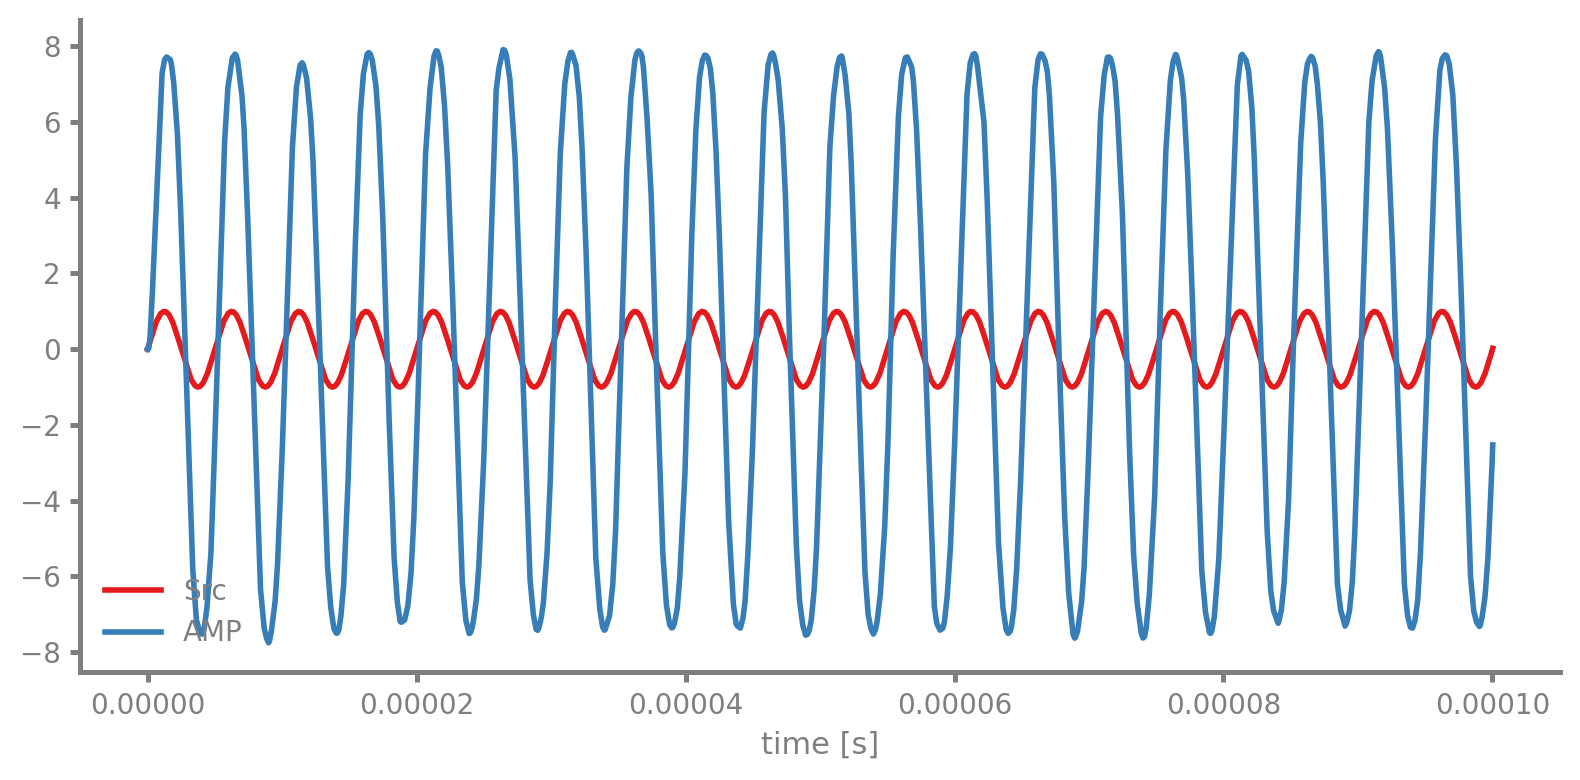

In [17]:
time, [res_src, res_amp] = Sco.read()

fig, ax = plt.subplots(nrows=1, figsize=(8, 4), tight_layout=True, dpi=200)

ax.plot(time, res_src, label=Sco.labels[0])
ax.plot(time, res_amp, label=Sco.labels[1])
ax.set_xlabel("time [s]")
ax.legend();

In the frequency domain we can see the second peak in te spectrum of the output signal. This indicates the nonlinearity.

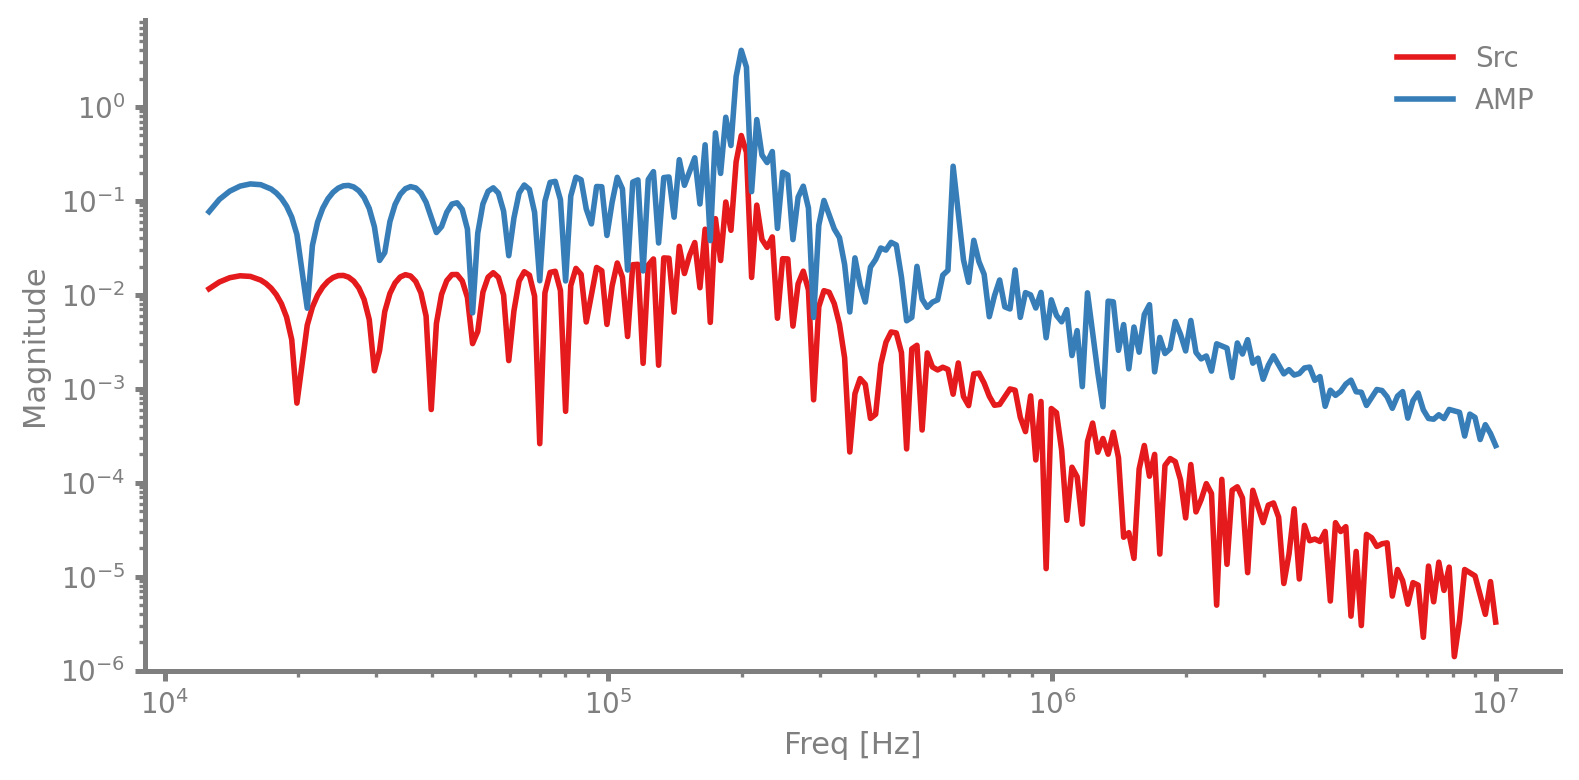

In [126]:
freq, [res_src, res_amp] = Spc.read()

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=200)

ax.loglog(freq, abs(res_src), label=Spc.labels[0])
ax.loglog(freq, abs(res_amp), label=Spc.labels[1])

ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("Magnitude")
ax.set_ylim(1e-6, None)
ax.legend();

## Sensitivity Analysis

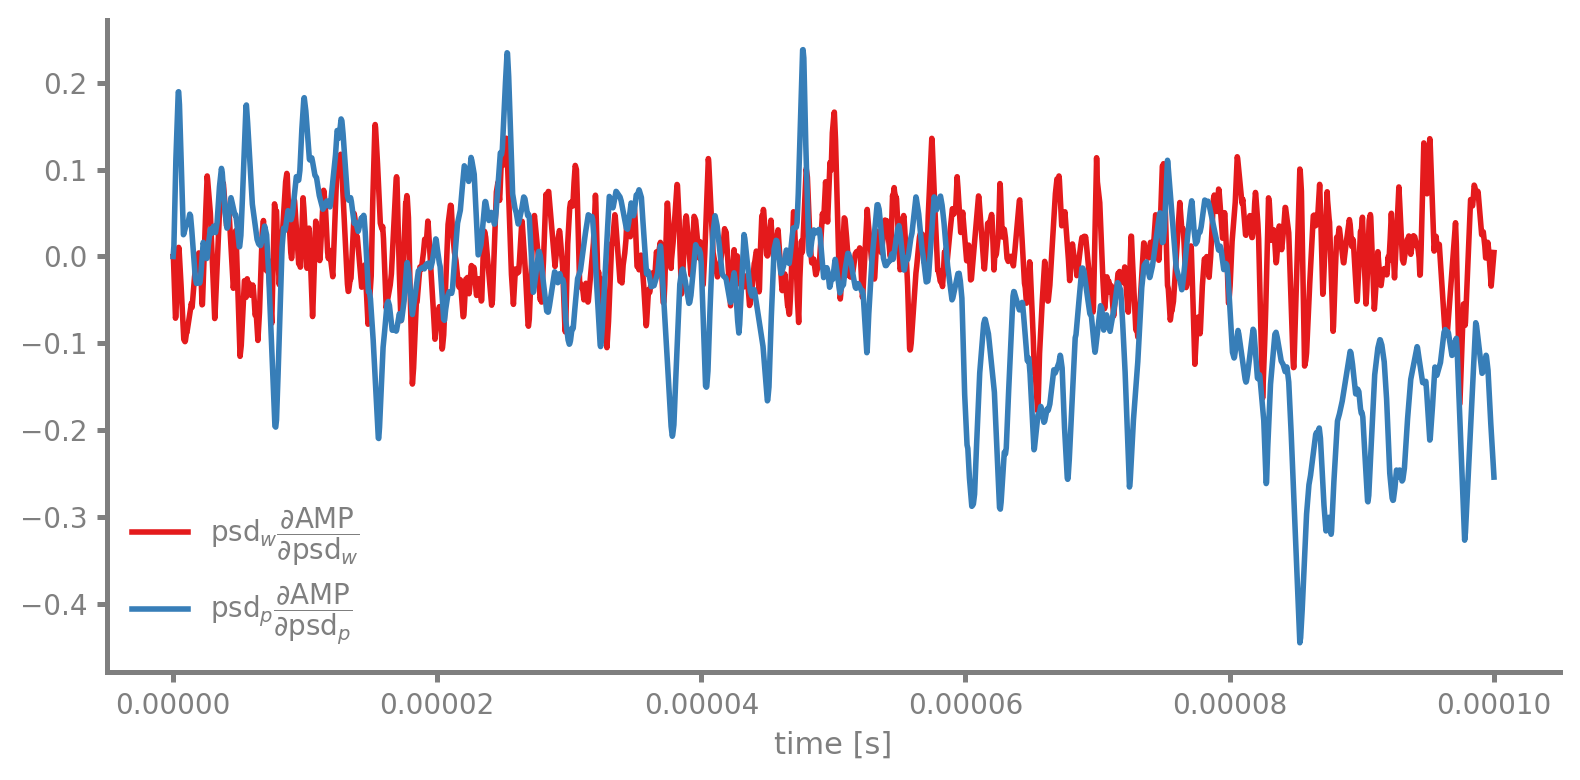

In [129]:
# time domain sensitivities

time, [res_src, res_amp] = Sco.read()

# extract partial derivatives
d_res_amp_d_psd_w = der(res_amp, psd_w)
d_res_amp_d_psd_p = der(res_amp, psd_p)

fig, ax = plt.subplots(nrows=1, figsize=(8, 4), tight_layout=True, dpi=200)

ax.plot(time, psd_w*d_res_amp_d_psd_w,
    label=r"$\mathrm{psd}_w \dfrac{\partial \mathrm{AMP}}{\partial \mathrm{psd}_w}$")
ax.plot(time, psd_p*d_res_amp_d_psd_p,
    label=r"$\mathrm{psd}_p \dfrac{\partial \mathrm{AMP}}{\partial \mathrm{psd}_p}$")

ax.set_xlabel("time [s]")
ax.legend();

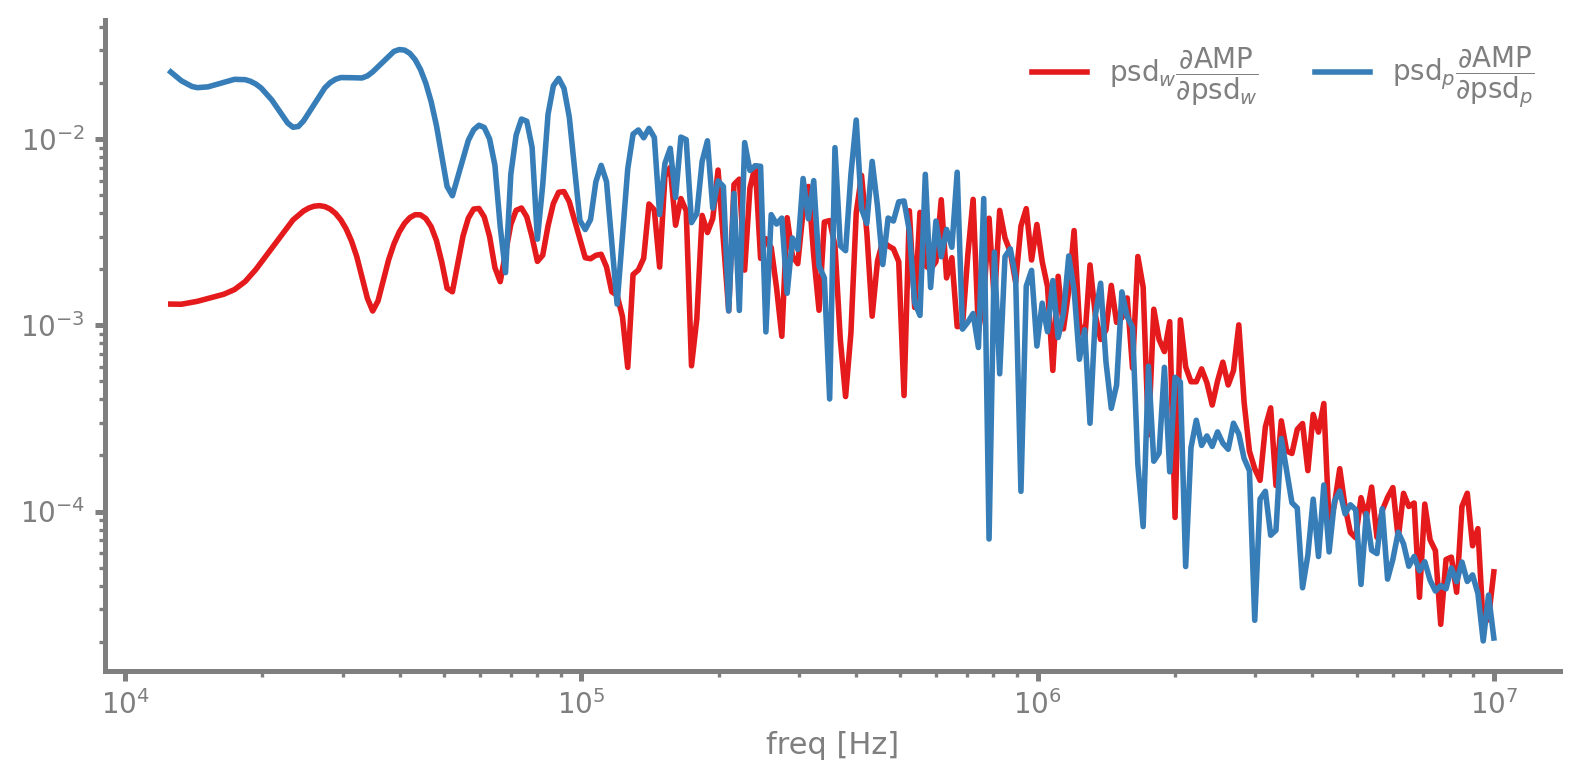

In [131]:
# spectral sensitivities

freq, [res_src, res_amp] = Spc.read()

# extract partial derivatives
d_res_amp_d_psd_w = der(res_amp, psd_w)
d_res_amp_d_psd_p = der(res_amp, psd_p)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=200)

ax.loglog(freq, abs(psd_w*d_res_amp_d_psd_w),
    label=r"$\mathrm{psd}_w \dfrac{\partial \mathrm{AMP}}{\partial \mathrm{psd}_w}$")
ax.loglog(freq, abs(psd_p*d_res_amp_d_psd_p), 
    label=r"$\mathrm{psd}_p \dfrac{\partial \mathrm{AMP}}{\partial \mathrm{psd}_p}$")
ax.set_xlabel("freq [Hz]")           
ax.legend(ncol=2);